In [36]:
import torch
from torch import nn
from torch.nn.functional import batch_norm
from torchinfo import summary
import matplotlib.pyplot as plt

In [85]:
cfg = {"test" :
        [32,32, "M", 64, 64, "M", 128, 128, 128, "M"]}

In [86]:
class my_VGGnet(nn.Module):
    def __init__(self, cfg, batch_norm = False, num_classes = 10, drop_p = 0.5):
        super().__init__()

        self.features = self.make_layers(cfg, batch_norm)


        self.classifier = nn.Sequential(nn.Linear(128 * 4 * 4, 512),
                                        nn.ReLU(),
                                        nn.Dropout(p = drop_p),
                                        nn.Linear(512, 512),
                                        nn.ReLU(),
                                        nn.Dropout(p = drop_p),
                                        nn.Linear(512, num_classes))


    def make_layers(self, cfg, batch_norm = False):
        layer = []
        in_channels = 3

        for v in cfg:
            if type(v) == int:
                if batch_norm:
                    layer += [nn.Conv2d(in_channels, v, 3, padding=1, bias = False),
                              nn.BatchNorm2d(v),
                              nn.ReLU()]
                else:
                    layer += [nn.Conv2d(in_channels, v, 3, padding = 1),
                              nn.ReLU()]
                in_channels = v
            else:
                layer += [nn.MaxPool2d(2)]

        return nn.Sequential(*layer)

    def forward(self,x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

class CNN_deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = nn.Sequential(nn.Conv2d(3,32,3,padding=1),
                                         nn.BatchNorm2d(32),
                                         nn.ReLU(),
                                         nn.Conv2d(32,32,3,padding=1),
                                         nn.BatchNorm2d(32),
                                         nn.ReLU())
        self.Maxpool1 = nn.MaxPool2d(2)

        self.conv_block2 = nn.Sequential(nn.Conv2d(32,64,3,padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(64,64,3,padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(64,64,3,padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU())
        self.Maxpool2 = nn.MaxPool2d(2)

        self.conv_block3 = nn.Sequential(nn.Conv2d(64,128,3,padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(128,128,3,padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(128,128,3,padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU())
        self.Maxpool3 = nn.MaxPool2d(2)

        self.classifier = nn.Sequential(nn.Linear(128*4*4,512),
                                       nn.Linear(512,10))

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.Maxpool1(x)
        x = self.conv_block2(x)
        x = self.Maxpool2(x)
        x = self.conv_block3(x)
        x = self.Maxpool3(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x


In [87]:
model = my_VGGnet(cfg["test"],batch_norm = True)
#model = CNN_deep()
summary(model, input_size=(1,3,32,32), device="mps")

Layer (type:depth-idx)                   Output Shape              Param #
my_VGGnet                                [1, 10]                   --
├─Sequential: 1-1                        [1, 128, 4, 4]            --
│    └─Conv2d: 2-1                       [1, 32, 32, 32]           864
│    └─BatchNorm2d: 2-2                  [1, 32, 32, 32]           64
│    └─ReLU: 2-3                         [1, 32, 32, 32]           --
│    └─MaxPool2d: 2-4                    [1, 32, 16, 16]           --
│    └─Conv2d: 2-5                       [1, 64, 16, 16]           18,432
│    └─BatchNorm2d: 2-6                  [1, 64, 16, 16]           128
│    └─ReLU: 2-7                         [1, 64, 16, 16]           --
│    └─Conv2d: 2-8                       [1, 64, 16, 16]           36,864
│    └─BatchNorm2d: 2-9                  [1, 64, 16, 16]           128
│    └─ReLU: 2-10                        [1, 64, 16, 16]           --
│    └─MaxPool2d: 2-11                   [1, 64, 8, 8]             --
│   

In [39]:
from multiclass_function_2 import *
import torch
from torchvision import datasets, transforms

In [88]:
BATCH_SIZE = 64
LR = 2e-3
LR_STEP = 3 # for LR STEP
LR_GAMMA = 0.9 # for LR STEP
EPOCH = 30
TRAIN_RATIO = 0.8
criterion = nn.CrossEntropyLoss()
new_model_train = True
model_type = "VGG_Test"
dataset = "CIFAR10"
save_model_path = f"./result/{model_type}_{dataset}.pt"
save_history_path = f"./result/{model_type}_history_{dataset}.pt"

transform_train = transforms.Compose([
    transforms.ToTensor()])
transform_test = transforms.ToTensor()

In [89]:
train_DS = datasets.CIFAR10(root = '/Users/sanghyun/Desktop/GIT_Folder', train = True, download=False, transform=transform_train)
test_DS = datasets.CIFAR10(root  = '/Users/sanghyun/Desktop/GIT_Folder', train = False, download=False, transform=transform_test)

In [90]:
NoT = int(len(train_DS)*TRAIN_RATIO)
NoV = len(train_DS) - NoT

train_DS, val_DS= torch.utils.data.random_split(train_DS, [NoT, NoV])

val_DS.transform = transform_test # test의 transform 적용!

train_DL = torch.utils.data.DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
val_DL = torch.utils.data.DataLoader(val_DS, batch_size=BATCH_SIZE, shuffle=True) # 이미지 변형 체크 할땐 False로
test_DL = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=True) # 이미지 변형 체크 할땐 False로

In [91]:
model = my_VGGnet(cfg["test"],batch_norm = True).to(DEVICE)
#model = CNN_deep().to(DEVICE)

Epoch: 1, current_LR = 0.002


train loss: 1.73588, val loss: 1.50726 
train acc: 35.1 %, val acc: 44.6 %, time: 7 s
--------------------
Epoch: 2, current_LR = 0.002


train loss: 1.38113, val loss: 1.24365 
train acc: 50.0 %, val acc: 54.8 %, time: 6 s
--------------------
Epoch: 3, current_LR = 0.002


train loss: 1.18499, val loss: 1.04832 
train acc: 57.8 %, val acc: 64.5 %, time: 6 s
--------------------
Epoch: 4, current_LR = 0.002


train loss: 1.03492, val loss: 1.00574 
train acc: 63.7 %, val acc: 64.3 %, time: 6 s
--------------------
Epoch: 5, current_LR = 0.002


train loss: 0.92244, val loss: 0.98488 
train acc: 67.7 %, val acc: 66.4 %, time: 6 s
--------------------
Epoch: 6, current_LR = 0.002


train loss: 0.84183, val loss: 0.83479 
train acc: 71.2 %, val acc: 70.8 %, time: 6 s
--------------------
Epoch: 7, current_LR = 0.002


train loss: 0.76384, val loss: 0.79047 
train acc: 74.0 %, val acc: 73.3 %, time: 6 s
--------------------
Epoch: 8, current_LR = 0.002


train loss: 0.69241, val loss: 0.81207 
train acc: 76.8 %, val acc: 72.7 %, time: 6 s
--------------------
Epoch: 9, current_LR = 0.002


train loss: 0.63363, val loss: 0.82711 
train acc: 78.7 %, val acc: 71.8 %, time: 6 s
--------------------
Epoch: 10, current_LR = 0.002


train loss: 0.57551, val loss: 0.86479 
train acc: 81.0 %, val acc: 72.4 %, time: 6 s
--------------------
Epoch: 11, current_LR = 0.002


train loss: 0.52593, val loss: 0.67195 
train acc: 82.6 %, val acc: 78.0 %, time: 6 s
--------------------
Epoch: 12, current_LR = 0.002


train loss: 0.48099, val loss: 0.71969 
train acc: 84.2 %, val acc: 75.8 %, time: 6 s
--------------------
Epoch: 13, current_LR = 0.002


train loss: 0.44279, val loss: 0.71681 
train acc: 85.7 %, val acc: 76.2 %, time: 6 s
--------------------
Epoch: 14, current_LR = 0.002


train loss: 0.40255, val loss: 0.78636 
train acc: 87.1 %, val acc: 74.3 %, time: 6 s
--------------------
Epoch: 15, current_LR = 0.002


train loss: 0.36938, val loss: 0.69948 
train acc: 87.8 %, val acc: 77.7 %, time: 7 s
--------------------
Epoch: 16, current_LR = 0.002


train loss: 0.34355, val loss: 0.68084 
train acc: 88.9 %, val acc: 77.3 %, time: 6 s
--------------------
Epoch: 17, current_LR = 0.002


train loss: 0.31204, val loss: 0.67697 
train acc: 90.1 %, val acc: 78.5 %, time: 6 s
--------------------
Epoch: 18, current_LR = 0.002


train loss: 0.29441, val loss: 0.73528 
train acc: 90.6 %, val acc: 76.2 %, time: 6 s
--------------------
Epoch: 19, current_LR = 0.002


train loss: 0.28306, val loss: 0.74696 
train acc: 91.1 %, val acc: 76.8 %, time: 6 s
--------------------
Epoch: 20, current_LR = 0.002


train loss: 0.26201, val loss: 0.72179 
train acc: 91.8 %, val acc: 79.3 %, time: 6 s
--------------------
Epoch: 21, current_LR = 0.002


train loss: 0.24457, val loss: 0.7241 
train acc: 92.4 %, val acc: 78.2 %, time: 6 s
--------------------
Epoch: 22, current_LR = 0.002


train loss: 0.23664, val loss: 0.79511 
train acc: 92.7 %, val acc: 77.4 %, time: 7 s
--------------------
Epoch: 23, current_LR = 0.002


train loss: 0.21881, val loss: 0.83492 
train acc: 93.2 %, val acc: 76.2 %, time: 6 s
--------------------
Epoch: 24, current_LR = 0.002


train loss: 0.19815, val loss: 0.78191 
train acc: 93.9 %, val acc: 78.7 %, time: 6 s
--------------------
Epoch: 25, current_LR = 0.002


train loss: 0.19626, val loss: 0.85336 
train acc: 93.9 %, val acc: 76.8 %, time: 6 s
--------------------
Epoch: 26, current_LR = 0.002


train loss: 0.19956, val loss: 0.77134 
train acc: 94.0 %, val acc: 77.9 %, time: 6 s
--------------------
Epoch: 27, current_LR = 0.002


train loss: 0.18219, val loss: 0.85504 
train acc: 94.4 %, val acc: 77.3 %, time: 6 s
--------------------
Epoch: 28, current_LR = 0.002


train loss: 0.16735, val loss: 0.83289 
train acc: 94.9 %, val acc: 77.9 %, time: 6 s
--------------------
Epoch: 29, current_LR = 0.002


train loss: 0.17043, val loss: 0.85289 
train acc: 94.8 %, val acc: 77.6 %, time: 6 s
--------------------
Epoch: 30, current_LR = 0.002


train loss: 0.16507, val loss: 0.79117 
train acc: 95.1 %, val acc: 78.6 %, time: 6 s
--------------------


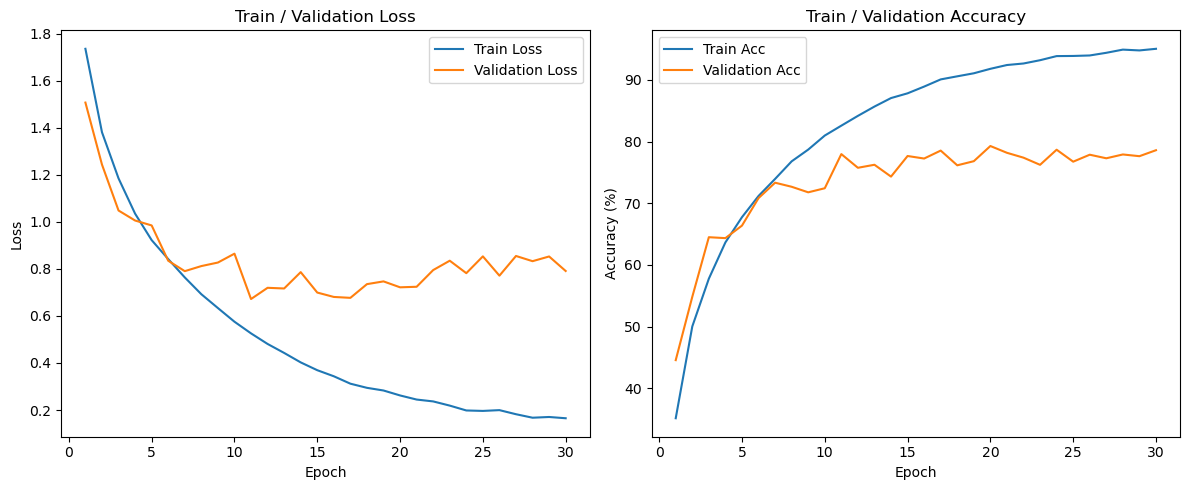

In [92]:
if new_model_train:
    optimizer = optim.Adam(model.parameters(), lr=LR)
    # loss_history = Train(model, train_DL, criterion, optimizer, EPOCH, )
    loss_history = Train(model, train_DL, val_DL, criterion, optimizer, EPOCH,
          BATCH_SIZE, TRAIN_RATIO,
          save_model_path, save_history_path)

    torch.save(model, save_model_path)

history = torch.load(save_history_path)
loss_history = history["loss_history"]
acc_history = history["acc_history"]

epochs = range(1, len(loss_history["train"]) + 1)

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_history["train"], label='Train Loss')
plt.plot(epochs, loss_history["val"], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train / Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, acc_history["train"], label='Train Acc')
plt.plot(epochs, acc_history["val"], label='Validation Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train / Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [93]:
Test(model, test_DL, criterion)


Test loss: 0.7726
Test accuracy: 7939/10000 (79.4 %)


79.4

In [82]:
Test(model, test_DL, criterion)


Test loss: 1.16485
Test accuracy: 8058/10000 (80.6 %)


80.6

1595050


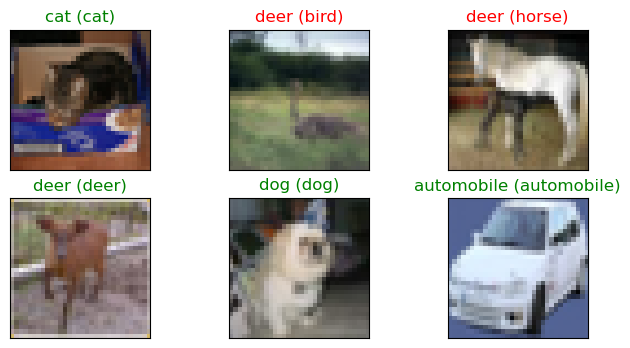

In [94]:
Test_plot(model, test_DL)
print(count_params(model))